## Bidirectional LSTM Model Training for CMAPSS RUL Prediction

In [21]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

In [22]:
# Load rolling window sequences (shape: [num_samples, window_size, num_features])
X = np.load("C:/Users/srija/Desktop/Infosys Springboard Intern/prognosAI-Infosys-intern-project/data/rolling_window_sequences.npy")      # Feature array
# Load metadata that contains engine_id, cycle, RUL, etc.
metadata = pd.read_csv("C:/Users/srija/Desktop/Infosys Springboard Intern/prognosAI-Infosys-intern-project/data/sequence_metadata_with_RUL.csv")
y = metadata["RUL"].values                     # Target RUL array

# Print shapes to verify
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (152559, 30, 66)
y shape: (152559,)


In [23]:
# Split into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)

# Inspect sample batches
print("Sample X_train[0] batch shape:", X_train[0].shape)
print("First 5 RUL targets:", y_train[:5])

Train shape: (122047, 30, 66) (122047,)
Val shape: (30512, 30, 66) (30512,)
Sample X_train[0] batch shape: (30, 66)
First 5 RUL targets: [ 56. 296.  86. 122. 121.]


In [24]:
# Data Pipeline / Generator (optional, for very large data)
# Keras can accept Numpy arrays directly in fit(), so for most practical cases, we can skip writing a custom generator
# If memory is a concern, use tf.data.Dataset.from_tensor_slices
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64).prefetch(1)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(64).prefetch(1)

In [25]:
# LSTM Model for RUL Prediction
model = Sequential([
    Bidirectional(LSTM(64, activation='tanh', input_shape=(X.shape[1], X.shape[2]), return_sequences=False)),
    Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mse')
model.build(input_shape=(None, X.shape[1], X.shape[2]))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirecti  (None, 128)               67072     
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 67201 (262.50 KB)
Trainable params: 67201 (262.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
# Traning Setup: Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1
)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1
)
model_ckpt = ModelCheckpoint('best_bidirectional_model.keras', monitor='val_loss', verbose=1
)

In [27]:
# Model Training
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr, model_ckpt]
)

Epoch 1/30
1905/1907 [============================>.] - ETA: 0s - loss: 13832.1729
Epoch 1: saving model to best_bidirectional_model.keras
1907/1907 [==============================] - 25s 11ms/step - loss: 13825.5889 - val_loss: 8504.1826 - lr: 0.0010
Epoch 2/30
1906/1907 [============================>.] - ETA: 0s - loss: 5706.2363
Epoch 2: saving model to best_bidirectional_model.keras
1907/1907 [==============================] - 19s 10ms/step - loss: 5705.2954 - val_loss: 4391.5044 - lr: 0.0010
Epoch 3/30
1907/1907 [==============================] - ETA: 0s - loss: 3993.2820
Epoch 3: saving model to best_bidirectional_model.keras
1907/1907 [==============================] - 20s 10ms/step - loss: 3993.2820 - val_loss: 3648.5413 - lr: 0.0010
Epoch 4/30
1906/1907 [============================>.] - ETA: 0s - loss: 3599.8232
Epoch 4: saving model to best_bidirectional_model.keras
1907/1907 [==============================] - 20s 10ms/step - loss: 3599.4021 - val_loss: 3403.0068 - lr: 0.001

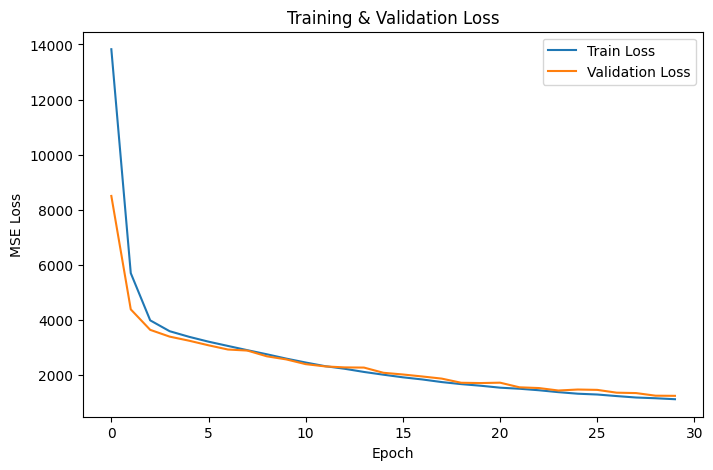

In [28]:
# Training and Validation Curves
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

7/7 [==============================] - 0s 4ms/step


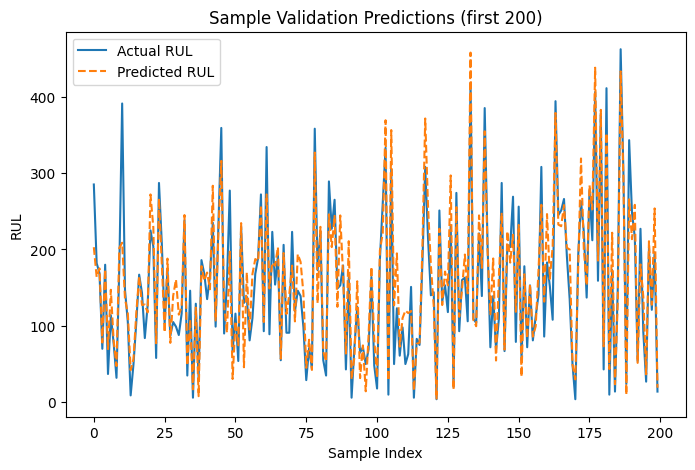

In [29]:
# Verify Model Predictions
val_pred = model.predict(X_val[:200]).flatten()
plt.figure(figsize=(8,5))
plt.plot(y_val[:200], label='Actual RUL')
plt.plot(val_pred, label='Predicted RUL', linestyle='--')
plt.title('Sample Validation Predictions (first 200)')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.legend()
plt.show()